In [15]:
from pafpy import PafFile
from tqdm.notebook import tqdm
from collections import defaultdict
from itertools import chain
import intervaltree as itree
from Bio import SeqIO
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
from collections import defaultdict
import scipy
import time
import re

plt.rcParams["figure.figsize"] = (10, 6)
plt.rcParams["figure.facecolor"] = "white"
plt.rcParams.update({'font.size': 18})


In [16]:
from glob import glob
# from hurry.filesize import size
import psutil
import shlex
import csv
from pathlib import Path
import itertools
import random
from pyfaidx import Fasta
from collections import namedtuple
from dataclasses import dataclass, field
from datetime import timedelta

In [17]:
human_assemblies = list(glob("/home/Users/blk6/Data/assemblies/human/GCA_*.fa"))
human_ref = "/home/Users/blk6/Data/reads/human/T2T_v2.1.fna"
yeast_pangenome = "ref-genomes/cerevisiae.pan.fa"

# Results analysis


In [18]:
target_index = Fasta("/home/Users/blk6/Data/reads/human/T2T_v2.1.fna")
query_index = Fasta("/home/Users/blk6/Data/assemblies/human/GCA_018466835.1.fa")
query_index = Fasta("/home/Users/blk6/Data/reads/human/PromethION_all_reads.fasta")

FastaNotFoundError: Cannot read FASTA from file /home/Users/blk6/Data/reads/human/T2T_v2.1.fna

In [20]:
qid_to_len = {rid: rec.unpadded_len for rid, rec in tqdm(query_index.items())}
tid_to_len = {rid: rec.unpadded_len for rid, rec in tqdm(target_index.items())}

NameError: name 'query_index' is not defined

In [21]:
Minimap2Params = namedtuple("Minimap2Params", "is_ont n")
MashMap3Params = namedtuple("MashMap3Params", "L k ss pi n")
MashMapParams = namedtuple("MashMapParams", "L k ss pi n tool")
ParameterSet = namedtuple("ParameterSet", "dataset mashmap2_params mashmap3_params minimap2_params")
Dataset = namedtuple("Dataset", "name reference queries")

@dataclass
class RunProfile:
    time: int = 0
    memory: int = 0

In [22]:
empty_fasta = "/home/Users/blk6/Data/reads/empty.fa"
human_assemblies = list(glob("/home/Users/blk6/Data/assemblies/human/GCA_*.fa"))
human_assembly_HG02257 = "/home/Users/blk6/Data/assemblies/human/GCA_018466835.1.fa"
human_ref = "/home/Users/blk6/Data/assemblies/human-ref/T2T_v2.1.fna"
HiFi_reads = "/home/Users/blk6/Data/reads/human/HiFi-5000-d2.fa"
ONT_reads = {ANI: f"/home/Users/blk6/Data/reads/human/ONT-{ANI}-nosd-d2-5000.fa" for ANI in [99, 98, 95]}
ONT_indel_balanced_reads = {ANI: f"/home/Users/blk6/Data/reads/human/ONT-{ANI}-nosd-balanced-d.5-5000.fa" for ANI in [99, 98, 95]}
yeast_pangenome = "/home/Users/blk6/Contribute/wfmash/ref-genomes/cerevisiae.pan.fa"

empty_dataset = Dataset("empty-dataset", human_ref, (empty_fasta,))
chm13_hifi_dataset = Dataset("chm13-HiFi-reads", human_ref, (HiFi_reads,))
chm13_ONT_datasets = {ANI: Dataset(f"chm13-ONT-{ANI}-reads", human_ref, (ONT_reads[ANI],)) for ANI in ONT_reads}
chm13_ONT_indel_balanced_datasets = {ANI: Dataset(f"chm13-ONT-indel-balanced-{ANI}-reads", human_ref, (ONT_indel_balanced_reads[ANI],)) for ANI in ONT_reads}
chm13_HG02257_dataset = Dataset("chm13-HG02257", human_ref, (human_assembly_HG02257,))
yeast_pangenome_dataset = Dataset("yeast-pangenome", yeast_pangenome, [])

In [195]:
bb_results = {
    "1": {"MashMap2": 0.274, "MashMap3": 0.021},
    "5": {"MashMap2": 0.120, "MashMap3": -0.006},
    "10": {"MashMap2": 0.079, "MashMap3": 0.020}}


In [23]:
ss_to_dens_5000 = {10: 0.0027033015587942942,
 20: 0.004999545524382726,
 30: 0.007225297850085516,
 40: 0.009414666280896978,
 50: 0.011580825266216262,
 60: 0.0137304687797538,
 70: 0.015867562596763904,
 75: 0.0169,
 80: 0.017994721638507495,
 90: 0.020113733315396117,
 100: 0.022225882956137456,
 110: 0.024332211034229525,
 120: 0.026433437214099118,
 130: 0.028530192910771867,
 140: 0.03062297923626709,
 150: 0.032712196059314504,
 160: 0.03479819307413521,
 170: 0.03688125618779697,
 180: 0.038961631636590104,
 190: 0.04103953307815283,
 200: 0.04310220928250878,
 300: 0.06375817159996389,
 400: 0.08429124072361874,
 500: 0.10474345862936014,
 600: 0.12513590112065218,
 700: 0.14548170418253295,
 800: 0.16578947227428895,
 900: 0.18606471061147348,
 1000: 0.206311821699839}

In [24]:
import re

Profile = namedtuple("Profile", ["cputime", "walltime", "memory"])

def file_to_profile(input_f):
    kbInGb = 1048576
    user, sys, walltime, cputime, memory = 0, 0, 0, 0, 0
    if not Path(input_f).exists():
        print(input_f, "does not exist!")
        return None
    with open(input_f) as profile_in:
        for line in profile_in:
            m = re.search(r'User time \(seconds\): (?P<time>\d+\D\d+)', line)
            if m:
                user = float(m.groupdict()["time"])
                continue
            m = re.search(r'System time \(seconds\): (?P<time>\d+\D\d+)', line)
            if m:
                sys = float(m.groupdict()["time"])
                continue
            m = re.search(r'Elapsed \(wall clock\) time \(h:mm:ss or m:ss\): (?P<time>\d+:\d+:\d+)', line)
            if m:
                h, mm, ss = m.groupdict()["time"].split(":")
                walltime = timedelta(seconds=float(ss), minutes=float(mm), hours=float(h))
                continue
            m = re.search(r'Elapsed \(wall clock\) time \(h:mm:ss or m:ss\): (?P<time>\d+:\d+.\d+)', line)
            if m:
                mm, ss = m.groupdict()["time"].split(":")
                walltime = timedelta(seconds=float(ss), minutes=float(mm))
                continue
            m = re.search(r'Maximum resident set size \(kbytes\): (?P<mem>\d+)', line)
            if m:
                memory = int(m.groupdict()["mem"])
                continue
            
            m = re.search(r'Exit status: (?P<status>\d+)', line)
            if m:
                # if m.groupdict()["status"] != "0":
                #     return None
                continue
        cputime = timedelta(seconds=user+sys)
    if (not (cputime and walltime and memory)):
        print("No timing data found in ", input_f)
        print(cputime, walltime, memory)
        return Profile(0, 0, 0)
    return Profile(np.round(cputime.total_seconds() / 60, 2), np.round(walltime.total_seconds() / 60, 2), np.round(memory / kbInGb, 2)) 

def print_profile(tool_to_profile):
    print(f"{'Method': ^40}\t{'CPU time (m)' : ^8}\t{'Wall time (m)' : ^8}\t{'Memory (GiB)' : ^8}")
    for tool, prof in tool_to_profile.items():
        if not prof:
            print(f"{tool: <40}\t{'...' : <8}\t{'...' : <8}\t{'...' : <8}")
        else:
            print(f"{tool: <40}\t{prof.cputime : <8}\t{prof.walltime : <8}\t{prof.memory : <8}")
            


Profile(cputime=5.12, walltime=2.3, memory=19.23)

In [25]:
def mm_params_to_paf(dataset_name, mm_params):
    run_base_name = f"{mm_params.tool}-ss{mm_params.ss}-k{mm_params.k}-p{mm_params.pi}-n{mm_params.n}-L{mm_params.L}"
    output_dir = f"/home/Users/blk6/Contribute/wfmash/benchmarking/{dataset_name}/{run_base_name}"
        
    return f"{output_dir}/{mm_params.tool}.approx.paf"


In [42]:
toolnames = [
    "mashmap2",
    "mashmap3"]
runs = defaultdict(list)

# HiFi run
default_pi = 95
L = 5000
n = 1

sketch_sizes = [20, 50, 80, 100, 150, 200, 300, 400]
kmers = [19]

for k in kmers:
    for ss in sketch_sizes:

        for ANI, dataset in chm13_ONT_indel_balanced_datasets.items():
            pi = ANI-5 # What should this be???
            for tool in toolnames:
                if "empty" in tool:
                    continue
                mm3_params = MashMapParams(L, k, ss, pi, n, tool=tool)
                runs[dataset].append(mm3_params)
                
                
for ANI, dataset in chm13_ONT_indel_balanced_datasets.items():
    mm3_params = MashMapParams(5000, 19, 150, 95, 1, tool="minimap2")
    runs[dataset].append(mm3_params)            



In [27]:
profile_dict = {dataset: {} for dataset in runs}
record_index_dict = {dataset: {param: defaultdict(list) for param in params} for (dataset, params) in runs.items()}
record_index_dict_J = {dataset: {param: defaultdict(list) for param in params} for (dataset, params) in runs.items()}

In [40]:

# IT_dicts = {dataset: {param: defaultdict(lambda: itree.IntervalTree()) for param in params} for (dataset, params) in runs.items()}

for dataset, params in tqdm(list((runs.items()))):
    for param in tqdm(params):
        try:
            paf_file_path = Path(mm_params_to_paf(dataset.name, param))
            if not paf_file_path.exists():
                print(f"Could not find {paf_file_path}")
                continue
            profile_dict[dataset][param] = file_to_profile(str(paf_file_path).replace(".approx.paf", ".err"))
            if not profile_dict[dataset][param]:
                print(str(paf_file_path).replace(".approx.paf", ".err"))
                raise
            with open(paf_file_path, 'r') as paf_reader:
                if param.tool == "minimap2":
                    if param.ss != 150:
                        continue
                    record_index_dict[dataset][param] = defaultdict(list)
                    reader = PafFile(paf_reader)
                    for record in tqdm(reader):
                        qname = record.qname.split("!")[0]
                        record_index_dict[dataset][param][qname].append(100 * (1 - record.tags["dv"].value))
                    for qname in record_index_dict[dataset][param].keys():
                        record_index_dict[dataset][param][qname] = sorted(record_index_dict[dataset][param][qname], key=lambda x: -x)
                else:
                    reader = csv.DictReader(paf_reader, delimiter='\t', fieldnames=["qname", "qlen", "qstart", "qend", "strand", "tname", "tlen", "tstart", "tend", "nmatches", "blen", "mapq", "tagANI", "tagJ"])
                    for idx, row in (enumerate(reader)):
                        qname = row["qname"].split("!")[0]
                        row["tagANI"] = float(row["tagANI"].split(":")[-1])
                        record_index_dict[dataset][param][qname].append(row["tagANI"])
                        row["tagJ"] = float(row["tagJ"].split(":")[-1]) if row["tagJ"] else ANI2j(row["tagANI"]/100, k)
                        record_index_dict_J[dataset][param][qname].append(row["tagJ"])
                    for qname in record_index_dict[dataset][param].keys():
                        record_index_dict[dataset][param][qname] = sorted(record_index_dict[dataset][param][qname], key=lambda x: -x)
                        record_index_dict_J[dataset][param][qname] = sorted(record_index_dict_J[dataset][param][qname], key=lambda x: -x)
        except Exception as e:
            print(e, param)
            raise e
            continue
            pass



  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

MashMapParams(L=5000, k=19, ss=100, pi=94, n=1, tool='mashmap2')
&  110.60 &  9.91 & -0.26 &  0.33 
MashMapParams(L=5000, k=19, ss=100, pi=94, n=1, tool='mashmap3')
&  43.83 &  12.13 &  0.03 &  0.24 
MashMapParams(L=5000, k=19, ss=150, pi=95, n=1, tool='minimap2')
&  210.88 &  9.87 & -0.26 &  0.43 


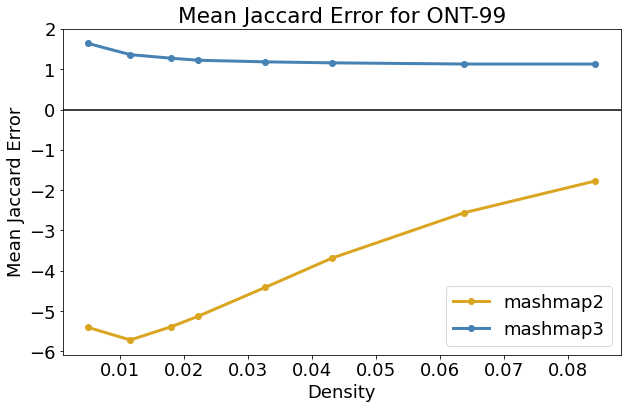

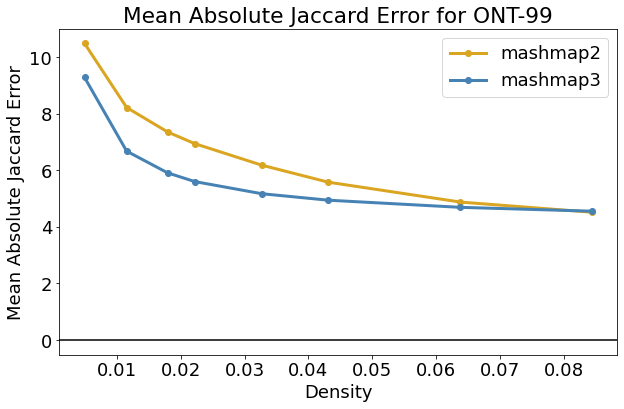

mashmap2
mashmap3


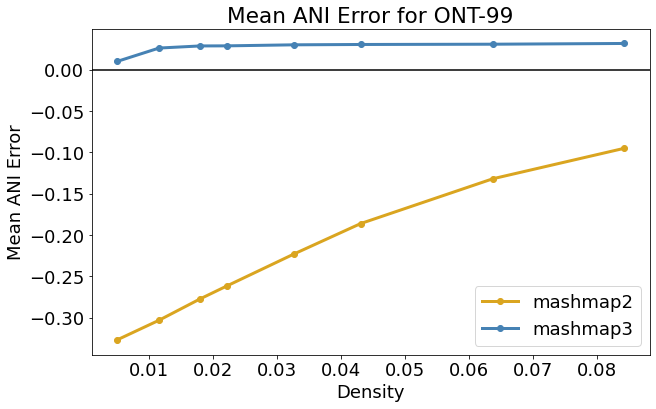

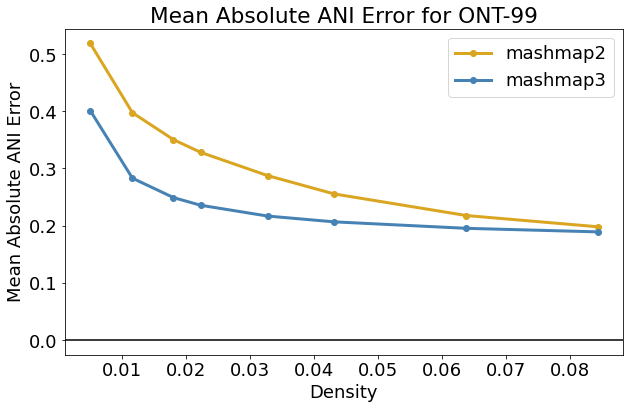

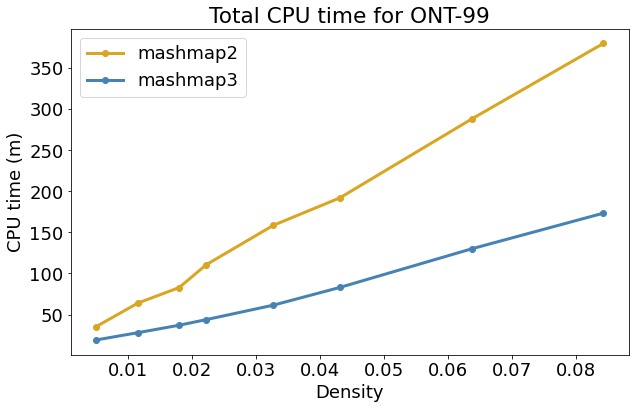

  0%|          | 0/17 [00:00<?, ?it/s]

MashMapParams(L=5000, k=19, ss=100, pi=93, n=1, tool='mashmap2')
&  112.69 &  9.91 & -0.32 &  0.44 
MashMapParams(L=5000, k=19, ss=100, pi=93, n=1, tool='mashmap3')
&  44.65 &  12.12 &  0.08 &  0.36 
MashMapParams(L=5000, k=19, ss=150, pi=95, n=1, tool='minimap2')
&  176.29 &  9.87 & -0.33 &  0.61 


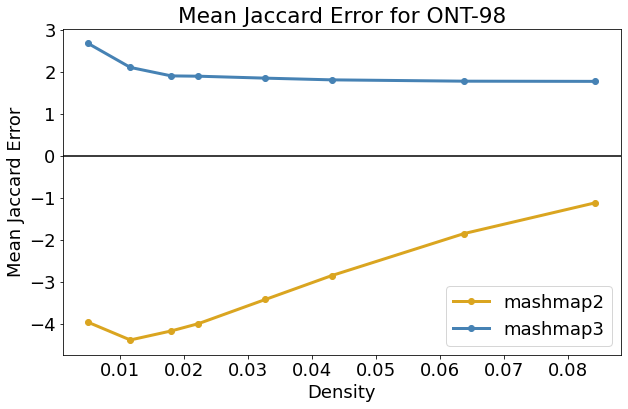

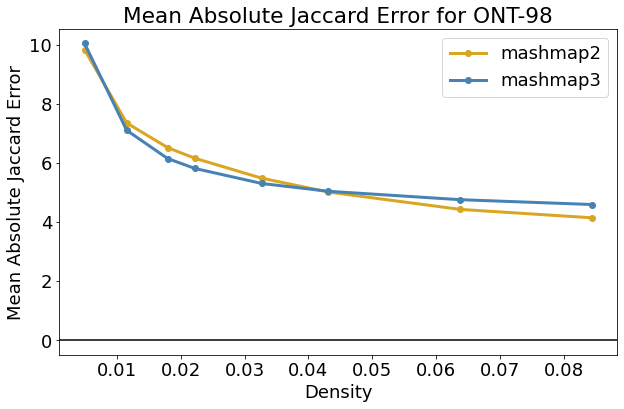

mashmap2
mashmap3


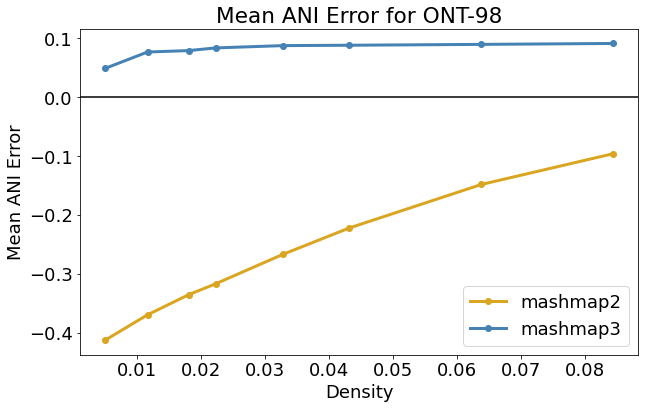

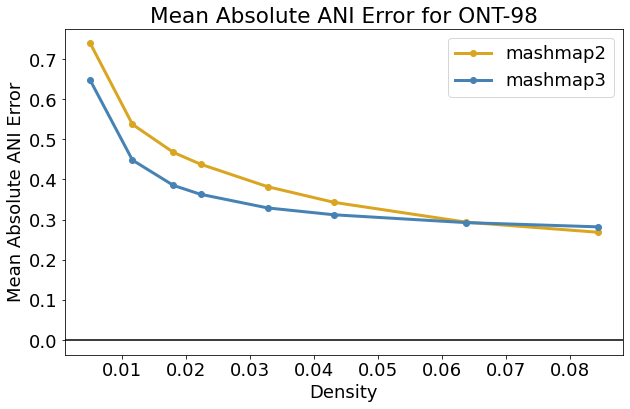

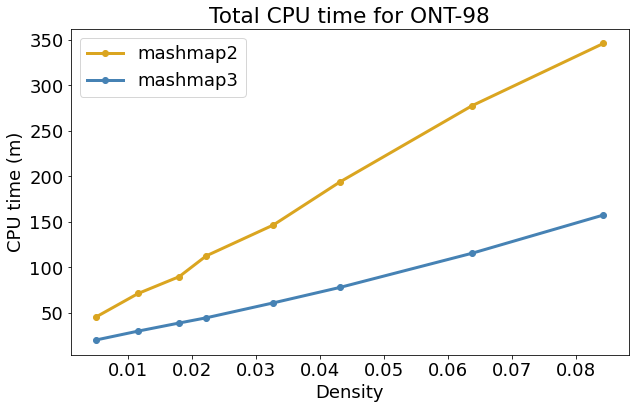

  0%|          | 0/17 [00:00<?, ?it/s]

MashMapParams(L=5000, k=19, ss=100, pi=90, n=1, tool='mashmap2')
&  169.66 &  9.91 & -0.13 &  0.66 
MashMapParams(L=5000, k=19, ss=100, pi=90, n=1, tool='mashmap3')
&  53.53 &  12.07 &  0.33 &  0.74 
MashMapParams(L=5000, k=19, ss=150, pi=95, n=1, tool='minimap2')
&  125.53 &  9.87 & -0.32 &  0.95 


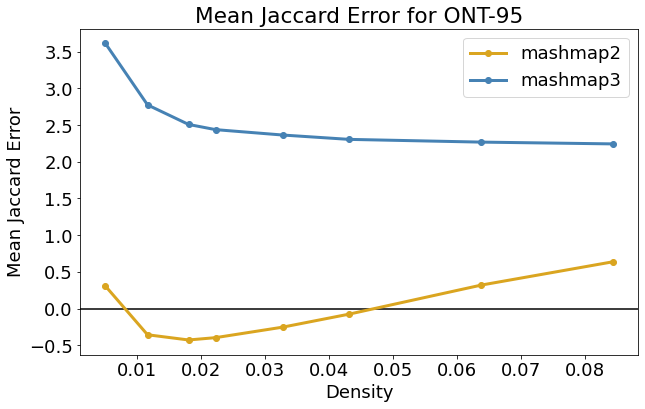

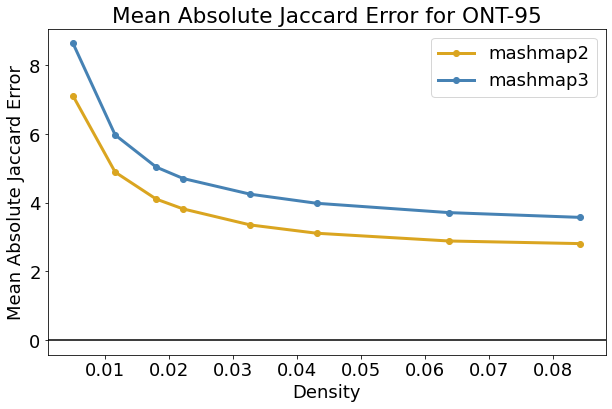

mashmap2
mashmap3


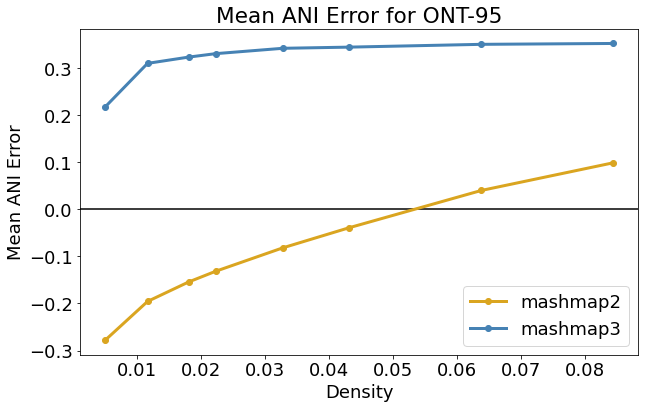

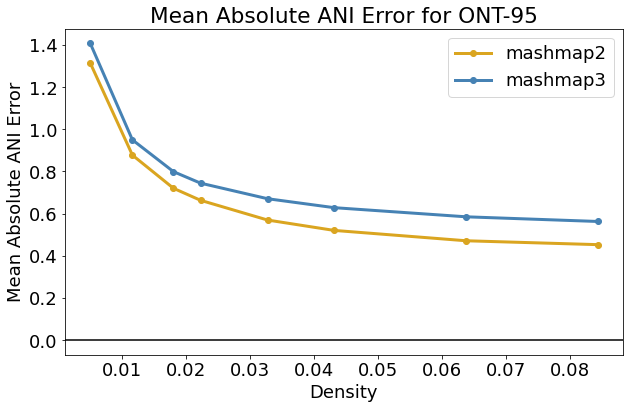

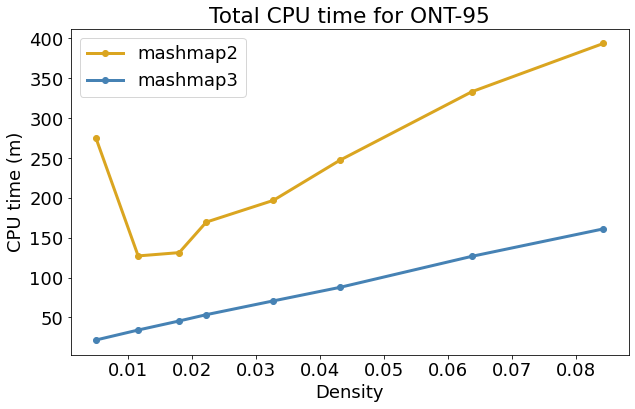

In [43]:
tool_to_color = {"mashmap2": "goldenrod", "mashmap3": "steelblue"}
k_to_marker = {19: "o", 17: "v"}
k_to_linestyle = {17: "dotted", 19: "solid"}
tools = ["mashmap2", "mashmap3", "minimap2"]

for ANI, dataset in [(ANI, chm13_ONT_indel_balanced_datasets[ANI]) for ANI in chm13_ONT_datasets.keys()]:
    kmer_to_ss_to_profile = {tool: defaultdict(lambda: {}) for tool in tools}
    kmer_to_ss_to_empty_profile  = {tool: defaultdict(lambda: {}) for tool in tools}
    kmer_to_ss_to_stats = {tool: defaultdict(lambda: defaultdict(lambda: list())) for tool in tools}
    kmer_to_ss_to_err = {tool: defaultdict(lambda: defaultdict(lambda: list())) for tool in tools}
    kmer_to_ss_to_err_J = {tool: defaultdict(lambda: defaultdict(lambda: list())) for tool in tools}
    kmer_to_ss_to_relerr = {tool: defaultdict(lambda: defaultdict(lambda: list())) for tool in tools}
    reported_ANIs = {tool: defaultdict(lambda: defaultdict(lambda: list())) for tool in tools}
    reported_Js = {tool: defaultdict(lambda: defaultdict(lambda: list())) for tool in tools}
    for param in tqdm(runs[dataset]):
        # if param.tool not in tools:
        #     continue
        rids = set([rid for rid in record_index_dict[dataset][param] if len(record_index_dict[dataset][param][rid]) > 0])
        if len(record_index_dict[dataset][param].values()):
            reported_ANIs[param.tool][param.k][param.ss] = {
                rid: record_index_dict[dataset][param][rid][0]
                for rid in ANI_to_gcANI[ANI].keys() if rid in rids
            }
            kmer_to_ss_to_profile[param.tool][param.k][param.ss] = profile_dict[dataset][param]
            # kmer_to_ss_to_empty_profile[param.tool][param.k][param.ss] = profile_dict[empty_dataset][MashMapParams(L=L, k=param.k, ss=param.ss, pi=default_pi, n=3, tool=param.tool)]
            stats_res = scipy.stats.describe(list(reported_ANIs[param.tool][param.k][param.ss].values()))
            kmer_to_ss_to_stats[param.tool][param.k][param.ss] = stats_res
            kmer_to_ss_to_relerr[param.tool][param.k][param.ss] = np.array([
                -100*(reported_ANIs[param.tool][param.k][param.ss][rid] - ANI_to_gcANI[ANI][rid]) / (100-ANI_to_gcANI[ANI][rid])
                for rid in ANI_to_gcANI[ANI] if rid in rids
            ])
            kmer_to_ss_to_err[param.tool][param.k][param.ss] = np.array([
                reported_ANIs[param.tool][param.k][param.ss][rid] - ANI_to_gcANI[ANI][rid]
                for rid in ANI_to_gcANI[ANI] if rid in rids
            ])
        if param.tool != "minimap2":
            if len(record_index_dict_J[dataset][param].values()):
                reported_Js[param.tool][param.k][param.ss] = {
                    rid: record_index_dict_J[dataset][param][rid][0]
                    for rid in ANI_to_J[ANI].keys() if rid in rids
                }
                kmer_to_ss_to_err_J[param.tool][param.k][param.ss] = np.array([
                    reported_Js[param.tool][param.k][param.ss][rid] - 100*ANI_to_J[ANI][rid]
                    for rid in ANI_to_J[ANI] if rid in rids
                ])
        
        if param.ss == 100 or  param.tool=="minimap2":
            print(param)
            errs = kmer_to_ss_to_err[param.tool][param.k][param.ss] 
            latex_str = f"& {kmer_to_ss_to_profile[param.tool][param.k][param.ss].cputime : .2f} & {kmer_to_ss_to_profile[param.tool][param.k][param.ss].memory : .2f}"
            latex_str += f" & {np.mean(errs) : .2f} & {np.mean(abs(errs)) : .2f} "
            print(latex_str)
    
    for tool in tools:
    # for tool in ["mashmap3"]:
        for k in sorted(kmer_to_ss_to_stats[tool].keys()):
            if tool == "minimap2":
                continue
            sketch_sizes = sorted(list(set(kmer_to_ss_to_stats[tool][k].keys())))
            plt.errorbar(
                [ss_to_dens_5000[ss] for ss in sketch_sizes], 
                [scipy.stats.describe(kmer_to_ss_to_err_J[tool][k][ss]).mean for ss in sketch_sizes], 
                # yerr=[scipy.stats.describe(kmer_to_ss_to_err_J[tool][k][ss]).variance for ss in sketch_sizes], 
                label=f"{tool}",
                linewidth=3,
                linestyle=k_to_linestyle[k],
                elinewidth=1,
                color=tool_to_color[tool],
                marker=k_to_marker[k],
                capsize=10)
    # if ANI < 95:
    #     plt.ylim((-3, 3))
    plt.title(f"Mean Jaccard Error for ONT-{ANI}")
    plt.xlabel("Density")
    plt.ylabel("Mean Jaccard Error")
    plt.axhline(0, color="black")
    plt.legend()
    plt.savefig(f'figures/J-ME-{ANI}.png', bbox_inches='tight')
    plt.show()
    
    for tool in tools:
        if tool == "minimap2":
                continue
    # for tool in ["mashmap3"]:
        for k in sorted(kmer_to_ss_to_stats[tool].keys()):
            sketch_sizes = sorted(list(set(kmer_to_ss_to_stats[tool][k].keys())))
            plt.errorbar(
                [ss_to_dens_5000[ss] for ss in sketch_sizes], 
                [scipy.stats.describe(abs(kmer_to_ss_to_err_J[tool][k][ss])).mean for ss in sketch_sizes], 
                # yerr=[scipy.stats.describe(kmer_to_ss_to_err_J[tool][k][ss]).variance for ss in sketch_sizes], 
                label=f"{tool}",
                linewidth=3,
                linestyle=k_to_linestyle[k],
                elinewidth=1,
                color=tool_to_color[tool],
                marker=k_to_marker[k],
                capsize=10)
    # if ANI < 95:
    #     plt.ylim((-3, 3))
    plt.title(f"Mean Absolute Jaccard Error for ONT-{ANI}")
    plt.xlabel("Density")
    plt.ylabel("Mean Absolute Jaccard Error")
    plt.axhline(0, color="black")
    plt.legend()
    plt.savefig(f'figures/J-MAE-{ANI}.png', bbox_inches='tight')
    plt.show()
    
    
    
    for tool in tools:
        if tool == "minimap2":
                continue
    # for tool in ["mashmap3"]:
        for k in sorted(kmer_to_ss_to_stats[tool].keys()):
            print(tool)
            sketch_sizes = sorted(list(set(kmer_to_ss_to_stats[tool][k].keys())))
            plt.errorbar(
                [ss_to_dens_5000[ss] for ss in sketch_sizes], 
                [scipy.stats.describe(kmer_to_ss_to_err[tool][k][ss]).mean for ss in sketch_sizes], 
                # yerr=[scipy.stats.describe(kmer_to_ss_to_err[tool][k][ss]).variance for ss in sketch_sizes], 
                label=f"{tool}",
                linewidth=3,
                linestyle=k_to_linestyle[k],
                elinewidth=1,
                color=tool_to_color[tool],
                marker=k_to_marker[k],
                capsize=10)
    # if ANI < 95:
    #     plt.ylim((-3, 3))
    plt.title(f"Mean ANI Error for ONT-{ANI}")
    plt.xlabel("Density")
    plt.ylabel("Mean ANI Error")
    plt.axhline(0, color="black")
    plt.legend()
    plt.savefig(f'figures/ANI-ME-{ANI}.png', bbox_inches='tight')
    plt.show()
    
    for tool in tools:
        if tool == "minimap2":
                continue
    # for tool in ["mashmap3"]:
        for k in sorted(kmer_to_ss_to_stats[tool].keys()):
            sketch_sizes = sorted(list(set(kmer_to_ss_to_stats[tool][k].keys())))
            plt.errorbar(
                [ss_to_dens_5000[ss] for ss in sketch_sizes], 
                [scipy.stats.describe(abs(kmer_to_ss_to_err[tool][k][ss])).mean for ss in sketch_sizes], 
                # yerr=[scipy.stats.describe(kmer_to_ss_to_err[tool][k][ss]).variance for ss in sketch_sizes], 
                label=f"{tool}",
                linewidth=3,
                linestyle=k_to_linestyle[k],
                elinewidth=1,
                color=tool_to_color[tool],
                marker=k_to_marker[k],
                capsize=10)
    # if ANI < 95:
    #     plt.ylim((-3, 3))
    plt.title(f"Mean Absolute ANI Error for ONT-{ANI}")
    plt.xlabel("Density")
    plt.ylabel("Mean Absolute ANI Error")
    plt.axhline(0, color="black")
    plt.legend()
    plt.savefig(f'figures/ANI-MAE-{ANI}.png', bbox_inches='tight')
    plt.show()
    
    for tool in tools:
        if tool == "minimap2":
                continue
        for k, ss_to_profile in sorted(kmer_to_ss_to_profile[tool].items()):
            sketch_sizes = sorted(list(ss_to_profile.keys()))
            plt.plot(
                [ss_to_dens_5000[ss] for ss in sketch_sizes], 
                [kmer_to_ss_to_profile[tool][k][ss].cputime for ss in sketch_sizes],
                label=f"{tool}",
                linewidth=3,
                linestyle=k_to_linestyle[k],
                color=tool_to_color[tool],
                marker=k_to_marker[k])
    plt.title(f"Total CPU time for ONT-{ANI}")
    plt.xlabel("Density")
    plt.ylabel("CPU time (m)")
    plt.legend()
    plt.savefig(f'figures/CPU-{ANI}.png', bbox_inches='tight')
    plt.show()
    

In [13]:
def j2ANI(j, k):
    return ((2*j)/(1+j))**(1/k)

def j2md(j, k):
    return 1 - j2ANI(j, k)

def ANI2j(ani, k):
    return (ani**k) / (2 - ani**k)

def md2j(md, k):
    return ANI2j(1-md, k)

print(ANI2j(.99, 19))

0.7038222359800587


95


  0%|          | 0/25 [00:00<?, ?it/s]

DescribeResult(nobs=31161, minmax=(93.56, 96.22), mean=94.99995699752897, variance=0.09404963871555483, skewness=-0.0857500737597496, kurtosis=0.06273806728005704)
98


  0%|          | 0/25 [00:00<?, ?it/s]

DescribeResult(nobs=31161, minmax=(97.16, 98.8), mean=98.00109752575335, variance=0.039402980250938274, skewness=-0.11868633254204893, kurtosis=0.05229426703260609)
99


  0%|          | 0/25 [00:00<?, ?it/s]

DescribeResult(nobs=31161, minmax=(98.4, 99.5), mean=99.00079650845608, variance=0.019902561959567477, skewness=-0.1270986298880605, kurtosis=0.019333645244075992)


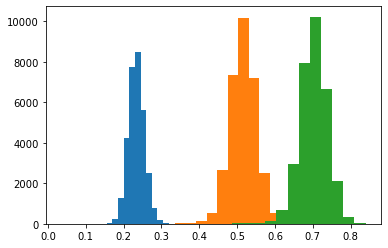

In [14]:
## from itertools import groupby
ANI_to_gcANI = defaultdict(dict)
ANI_to_J = defaultdict(dict)
ANI_to_length =  defaultdict(dict)
ANI_to_regANI = defaultdict(dict)
ANI_to_complexityPair = defaultdict(dict)
ANI_to_jointComp = defaultdict(dict)
k = 19

gap_regex = re.compile(r'(-)+')

for ANI in [95, 98, 99]:
    maf_files = glob(f"/home/Users/blk6/Data/reads/human/pbsim/ONT-{ANI}-nosd-noins-d.05-5000_00*.maf")
    if len(maf_files) == 0:
        continue
    print(ANI)
    distances = []
    for maf_file in tqdm(maf_files):
        counter = 0
        num_lines = sum(1 for line in open(maf_file))
        for line_no, line in (enumerate(line.strip() for line in open(maf_file))):
            if line == "":
                continue
            if line[0] == "a":
                if counter == 2:
                    match_columns = sum(ref_aln[i] == query_aln[i] for i in range(len(query_aln)))
                    mismatch_column_idxs = [i for i in range(len(query_aln)) if ref_aln[i] != query_aln[i]]
                    distances.extend([mismatch_column_idxs[i] - mismatch_column_idxs[i-1] for i in range(1, len(mismatch_column_idxs))])
                    # gap_columns_compressed_extra = sum((x[0] == '-')*(len(x)-1) for x in ["".join(grp) for num, grp in groupby(query_aln + ref_aln)])
                    s = query_aln + "SEP" + ref_aln
                    gap_columns_compressed_extra = s.count("-") - len(gap_regex.findall(s))
                    total_columns = len(ref_aln)
                    # print(match_columns / total_columns)
                    if random.random() < 1:
                        ref_aln = ref_aln.replace("-", "")
                        query_aln = query_aln.replace("-", "")
                        ref_set = set(ref_aln[i:i+k] for i in range(len(ref_aln)-k+1))
                        query_set = set(query_aln[i:i+k] for i in range(len(query_aln)-k+1))
                        ANI_to_J[ANI][rid] = len(ref_set & query_set) / len(ref_set | query_set) 
                    ANI_to_gcANI[ANI][rid] = 100*match_columns / (total_columns - gap_columns_compressed_extra)
                    ANI_to_regANI[ANI][rid] = 100*match_columns / (total_columns)
                    ANI_to_length[ANI][rid] = (len(ref_aln), len(query_aln))
                counter = 0
            elif line[0] == "s" and counter == 0:
                counter += 1
                ref_aln = line.split(" ")[-1].upper()
            elif line[0] == "s" and counter == 1:
                rid = line.split(" ")[1]
                query_aln = line.split(" ")[-1].upper()
                counter += 1
    print(scipy.stats.describe(list(ANI_to_gcANI[ANI].values())))
    plt.hist(list(ANI_to_J[ANI].values()), bins=20)
    # plt.show()
